In [32]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import gif2numpy
import pandas as pd
import os
from scipy import signal
import math
from itertools import combinations

In [33]:
##############
## Functions

def getContour(img):
    return max(cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)[0],key=len)

def generateChainCode(ListOfPoints): 
    chainCode = [] 
    for i in range(len(ListOfPoints) - 1): 
        a = ListOfPoints[i][0]
        b = ListOfPoints[i + 1][0]
        if b[1] - a[1] > 0:
            if b[0] - a[0] > 0:
                code = 7
            elif b[0] - a[0] == 0:
                code = 0
            elif b[0] - a[0] < 0:
                code = 1
        elif b[1] - a[1] == 0:
            if b[0] - a[0] > 0:
                code = 6
            elif b[0] - a[0] == 0:
                code = -1
            elif b[0] - a[0] < 0:
                code = 2
        elif b[1] - a[1] < 0:
            if b[0] - a[0] > 0:
                code = 3
            elif b[0] - a[0] == 0:
                code = 4
            elif b[0] - a[0] < 0:
                code = 5
        chainCode.append(code) 
    return chainCode

def getPerimeter(contours):
    return cv.arcLength(contours,True)

def getArea(contours):
    return cv.contourArea(contours)

def getCentroide(contours):
    M = cv.moments(contours)
    return int(M['m01']/M['m00']), int(M['m10']/M['m00'])

def allDistFromCentroide(contours, centroide):
    dists = []
    for i in contours:
        dists.append(np.linalg.norm(i[0] - np.array(centroide)))
    return dists

def getCircularidade(area, perimetro):
    return 4 * np.pi * area / perimetro ** 2

def getMajorMinorAxis(contours):
    return cv.fitEllipse(contours)[1:]

def getHuMoments(contour):
    moments = cv.moments(contour)
    return cv.HuMoments(moments)

In [34]:
def plotPcaAxis(data, color, pca_axis):
    comb = list(combinations(range(len(pca_axis)), 2))
    plt.figure(figsize=(12,12*len(comb)))
    for i in range(len(comb)):
        plt.subplot(len(comb), 1, i+1)
        plt.scatter(x=np.dot(data, pca_axis[comb[i][0]]), y=np.dot(data, pca_axis[comb[i][1]]), c=color)
        plt.xlabel("PCA {}".format(comb[i][0]+1))
        plt.ylabel("PCA {}".format(comb[i][1]+1))
    plt.show()
    
def plotHuAxis(data, color):
    data = np.array(data).T
    comb = list(combinations(range(len(data)), 2))
    plt.figure(figsize=(12,12*len(comb)))
    for i in range(len(comb)):
        plt.subplot(len(comb), 1, i+1)
        plt.scatter(x=data[comb[i][0]], y=data[comb[i][1]], c=color)
        plt.xlabel("H{}".format(comb[i][0]+1))
        plt.ylabel("H{}".format(comb[i][1]+1))
    plt.show()

In [35]:
imgs = os.listdir('imagens')
imgs_data = []

for img in imgs:
    img_read = gif2numpy.convert('imagens/{}'.format(img))[0][0]
    gray = cv.cvtColor(img_read, cv.COLOR_RGB2GRAY)
    gray = cv.GaussianBlur(gray, (5,5), 0)
    cv.threshold(gray,127,255,cv.THRESH_BINARY)
    data = {}
    contorno = getContour(gray)
    centroide = getCentroide(contorno)
    all_dists = allDistFromCentroide(contorno, centroide)
    area = getArea(contorno)
    perimetro = getPerimeter(contorno)
    mmaxis = getMajorMinorAxis(contorno)
    hu_moments = getHuMoments(contorno)
    data['Max dist / min'] = np.max(all_dists) / np.min(all_dists)
    data['Dist std'] = np.std(all_dists)
    data['Circularidade'] = getCircularidade(area, perimetro)
    data['Capacidade'] = perimetro ** 2 / area
    data['H0'] = hu_moments[0][0]
    data['H1'] = hu_moments[1][0]
    data['H2'] = hu_moments[2][0]
    data['H3'] = hu_moments[3][0]
    data['H4'] = hu_moments[4][0]
    data['H5'] = hu_moments[5][0]
    data['H6'] = hu_moments[6][0]
    imgs_data.append(data)
    
df_h = pd.DataFrame(imgs_data) 
df_imgs = pd.DataFrame({
    'Nome': imgs
})
df_imgs['Classes'] = [0 if 'dog' in a else 1 for a in imgs]
df = df_imgs.join(df_h)

In [36]:
df.head(10)

,Nome,Classes,Capacidade,Circularidade,Dist std,H0,H1,H2,H3,H4,H5,H6,Max dist / min
0,elephant-16.gif,1,48.887780,0.257045,37.000036,0.190078,0.002302,0.000251,0.000013,3.360685e-10,-4.494208e-07,-6.604347e-10,3.214263
1,dog-2.gif,0,61.294587,0.205016,46.251816,0.320648,0.039128,0.001119,0.000248,-1.147863e-07,2.178124e-05,6.242185e-08,24.027195
2,elephant-5.gif,1,62.707353,0.200397,104.754113,0.188806,0.001737,0.000372,0.000117,6.562119e-09,1.487439e-06,-2.351659e-08,6.433706
3,elephant-2.gif,1,50.015043,0.251252,69.777468,0.189171,0.001804,0.000030,0.000075,1.627318e-09,-2.240395e-06,3.202034e-09,3.003606
4,elephant-10.gif,1,51.288164,0.245015,27.449683,0.175879,0.000313,0.000083,0.000028,-1.157239e-09,2.042755e-09,-6.654314e-10,3.459576
5,dog-19.gif,0,48.984299,0.256539,62.517700,0.258718,0.013168,0.005201,0.000053,1.890767e-08,1.526987e-06,2.095212e-08,5.442451
6,elephant-8.gif,1,63.346950,0.198374,120.213130,0.200762,0.003362,0.000231,0.000104,-1.059742e-08,-1.249785e-06,1.202066e-08,22.519436
7,elephant-6.gif,1,72.475647,0.173387,122.420189,0.194775,0.003163,0.000197,0.000112,-1.301104e-09,6.049263e-07,1.659022e-08,32.729098
8,elephant-1.gif,1,61.011188,0.205968,64.553172,0.186950,0.001242,0.000140,0.000062,-3.769903e-09,-2.068707e-06,-4.318284e-09,3.538177
9,elephant-13.gif,1,43.229171,0.290692,84.920510,0.184765,0.002102,0.000329,0.000047,-5.754113e-09,-1.816097e-06,7.758527e-10,23.329103


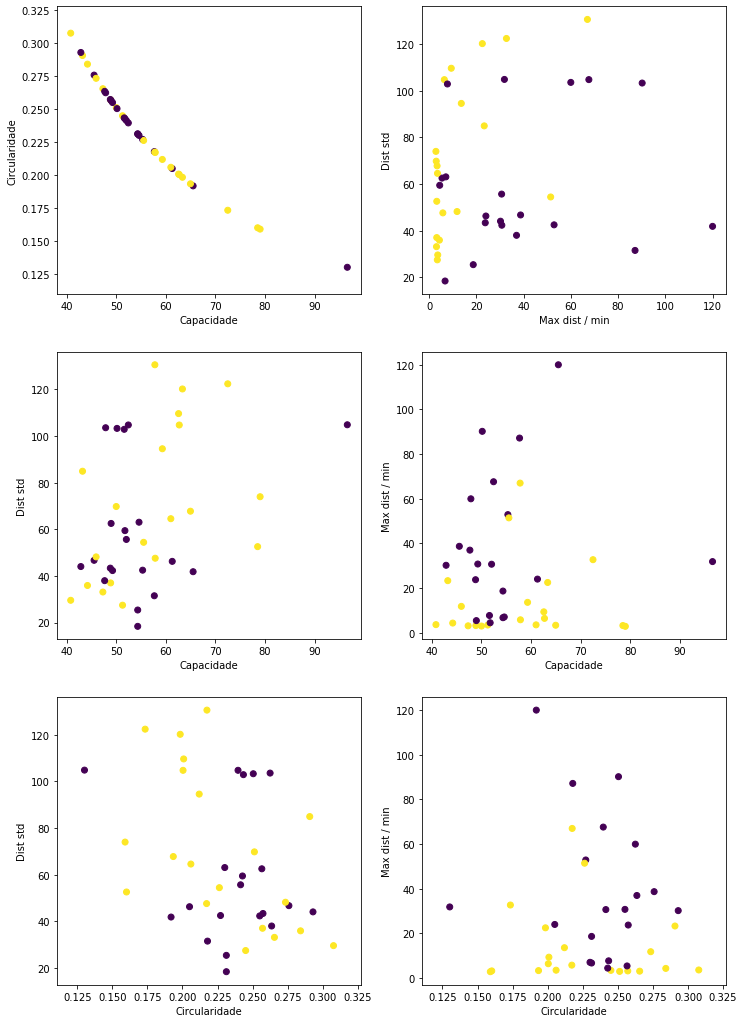

In [37]:
plt.figure(figsize=(12,18))
plt.subplot(3,2,1)
plt.scatter(x=df["Capacidade"], y=df["Circularidade"], c=df['Classes'])
plt.xlabel("Capacidade")
plt.ylabel("Circularidade")
plt.subplot(3,2,2)
plt.scatter(x=df["Max dist / min"], y=df["Dist std"], c=df['Classes'])
plt.xlabel("Max dist / min")
plt.ylabel("Dist std")
plt.subplot(3,2,3)
plt.scatter(x=df["Capacidade"], y=df["Dist std"], c=df['Classes'])
plt.xlabel("Capacidade")
plt.ylabel("Dist std")
plt.subplot(3,2,4)
plt.scatter(x=df["Capacidade"], y=df["Max dist / min"], c=df['Classes'])
plt.xlabel("Capacidade")
plt.ylabel("Max dist / min")
plt.subplot(3,2,5)
plt.scatter(x=df["Circularidade"], y=df["Dist std"], c=df['Classes'])
plt.xlabel("Circularidade")
plt.ylabel("Dist std")
plt.subplot(3,2,6)
plt.scatter(x=df["Circularidade"], y=df["Max dist / min"], c=df['Classes'])
plt.xlabel("Circularidade")
plt.ylabel("Max dist / min")
plt.show()

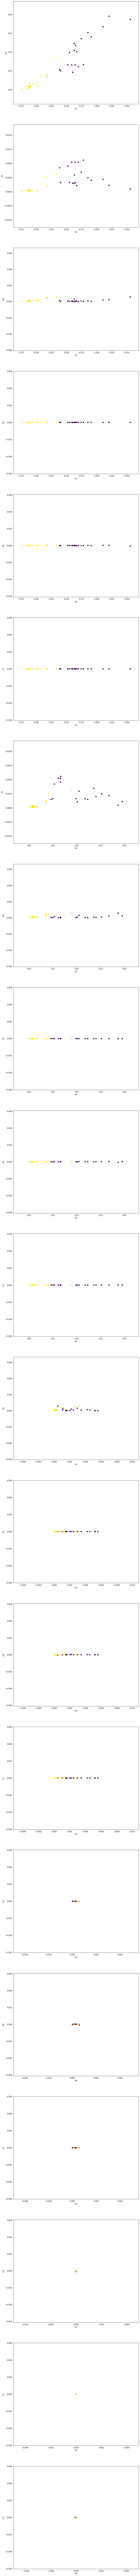

In [38]:
plotHuAxis(df.loc[:,"H0":"H6"], df['Classes'])

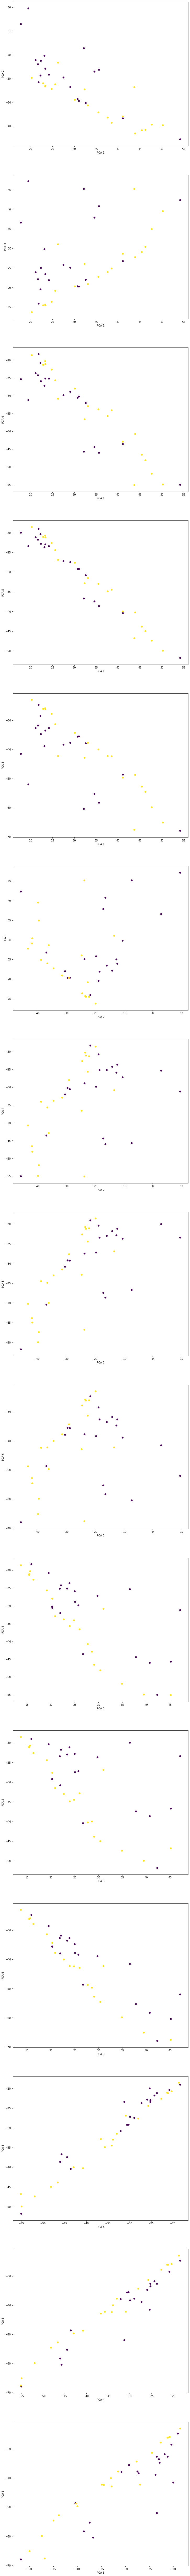

0.9281796603820844

In [39]:
def pca(m_attr, min_var):
    m_attr = np.array(m_attr)
    mcp = np.corrcoef(m_attr.T)
    mcp = np.nan_to_num(mcp)
    eigvalues, eigvectors = np.linalg.eig(mcp)
    sum_v = np.sum(eigvalues)
    current = 0
    zipped = list(zip(eigvalues, eigvectors))
    zipped.sort()
    components = []
    while current/sum_v < min_var:
        axis = zipped.pop()
        components.append(axis)
        current += axis[0]
    eigvalues, eigvectors = zip(*components)
    return eigvectors, current/sum_v
    
mpc = pca(df.loc[:,"Capacidade":], .9)
plotPcaAxis(df.loc[:,"Capacidade":], df['Classes'], mpc[0])
mpc[1]